# imports

In [902]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import copy
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from scipy.spatial import distance
from matplotlib import ticker
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
#%matplotlib widget
#%matplotlib qt

# class

In [903]:
class KMeans:
    
    def __init__(self, k_clusters=8):
        self.k_clusters=k_clusters
        self.n_iter=0
        self.sc=np.Inf
    
    def fit(self, X:np.ndarray):
        self.X=X
        self.P=np.zeros((self.X.shape[0], 1))
        self.C=self.X[np.random.randint(self.X.shape[0], size=self.k_clusters),:]
    
    def __predict_one(self, dist_f = 'euclidean', n_iterations=100):
        self.P=np.zeros((self.X.shape[0], 1))
        self.C=self.X[np.random.randint(self.X.shape[0], size=self.k_clusters),:]
        self.n_iter=0
        
        while self.n_iter<n_iterations:
            
            prev_P=copy.copy(self.P)
            prev_C=copy.copy(self.C)
            
            self.__choose_clusters(dist_f=dist_f)
            self.___new_centers()
            
            self.n_iter+=1
            if np.all(prev_P == self.P) or np.all(prev_C == self.C):
                break
            
        return self.P
    
    def predict(self, dist_f = 'euclidean' ,n_iterations=100, n_init=10) -> np.ndarray:
        
        self.n_init=n_init
        best_P=self.P
        best_C=self.C
        best_score=self.sc
        best_n_iter=self.n_iter
        
        for i in range(self.n_init):
            self.__predict_one(dist_f, n_iterations)
            sc=self.score()
            
            if best_score > sc:
                best_P=self.P
                best_C=self.C
                best_score=sc
                best_n_iter=self.n_iter
        
        self.P=best_P
        self.C=best_C
        self.sc=best_score
        self.n_iter=best_n_iter
        
        return self.P
            
    def __choose_clusters(self,dist_f='euclidean'):
        
            dist=distance.cdist(self.X, self.C,dist_f)
            clusters=np.argsort(dist, axis=1)[:,0]
            self.P[:,0]=clusters
            
    def ___new_centers(self):
        for i in range(self.k_clusters):
            index=np.where(self.P.ravel()==i)[0]
            rows=self.X[index,:]
            m=np.mean(rows,axis=0)
            
            if np.isnan(m).any():
                m=self.X[np.random.randint(self.X.shape[0], size=1),:]
                
            self.C[i,:]=m
            
    def score_variance(self):
        self.vars=np.nan_to_num(np.array([np.var(self.X[np.where(self.P==i),:]) for i in range(self.k_clusters)]),0)
        return self.vars
    
    def score(self, dist_f = 'euclidean'):
        
        dist=distance.cdist(self.C, self.C, dist_f)
        dist=np.triu(dist).sum()
        
        dist2=0
        for i in range(self.k_clusters):
            X=self.X[np.where(self.P==i),:][0]
            dist_X=distance.cdist( X, np.broadcast_to(self.C[i,:], X.shape), dist_f)[:,0]
            dist2+=dist_X.sum()
            
        self.sc=dist/dist2
        return self.sc
    

# dataset

In [904]:
df=pd.read_csv('autos.csv',index_col='Unnamed: 0')
print(df.columns)
print('number of unique makes:',df['make'].nunique())
df.head()

Index(['normalized-losses', 'make', 'fuel-type', 'aspiration', 'num-of-doors',
       'body-style', 'drive-wheels', 'engine-location', 'wheel-base', 'length',
       'width', 'height', 'curb-weight', 'engine-type', 'num-of-cylinders',
       'engine-size', 'fuel-system', 'bore', 'stroke', 'compression-ratio',
       'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price',
       'symboling'],
      dtype='object')
number of unique makes: 22


,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,...,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price,symboling
0,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,...,mpfi,3.47,2.68,9.0,111.0,5000.0,21.0,27.0,13495.0,3
1,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,...,mpfi,3.47,2.68,9.0,111.0,5000.0,21.0,27.0,16500.0,3
2,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,...,mpfi,2.68,3.47,9.0,154.0,5000.0,19.0,26.0,16500.0,1
3,164.0,audi,gas,std,four,sedan,fwd,front,99.8,176.6,...,mpfi,3.19,3.40,10.0,102.0,5500.0,24.0,30.0,13950.0,2
4,164.0,audi,gas,std,four,sedan,4wd,front,99.4,176.6,...,mpfi,3.19,3.40,8.0,115.0,5500.0,18.0,22.0,17450.0,2


# Autos 2d

In [905]:
km=KMeans(k_clusters=5)
col1='length'
col2='width'
X=np.vstack([df[col1].fillna(0),df[col2].fillna(0)]).T

km.fit(X)
clasters=km.predict(n_init=1000)
#print('centers:\n',km.C,sep='')

# plot

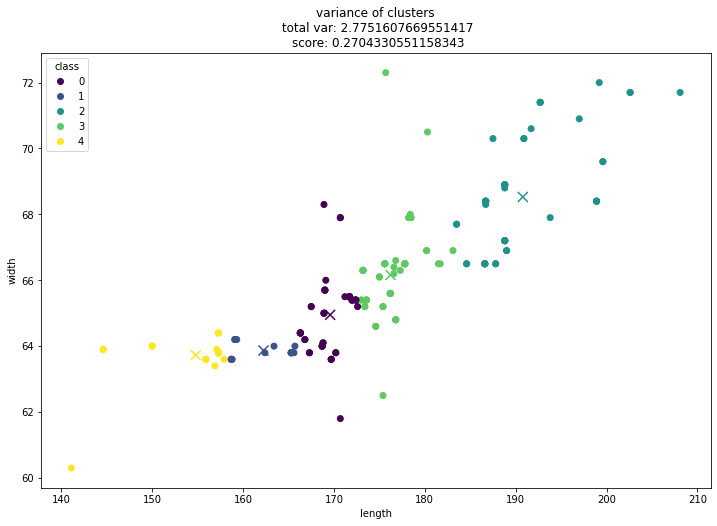

In [906]:
fig,ax=plt.subplots(1,1,figsize=(12,8))
ax.set_xlabel(col1)
ax.set_ylabel(col2)
ax.set_title(f'variance of clusters\n total var: {vars.sum()}\n score: {km.sc}')

scat=ax.scatter(X[:,0],X[:,1],c=clasters)
plt.legend(handles=scat.legend_elements()[0], labels=list(range(km.k_clusters)), title="class")
ax.scatter(km.C[:,0],km.C[:,1],c=list(range(km.k_clusters)),marker='x',s=100)

plt.show()

# Quality of grouping

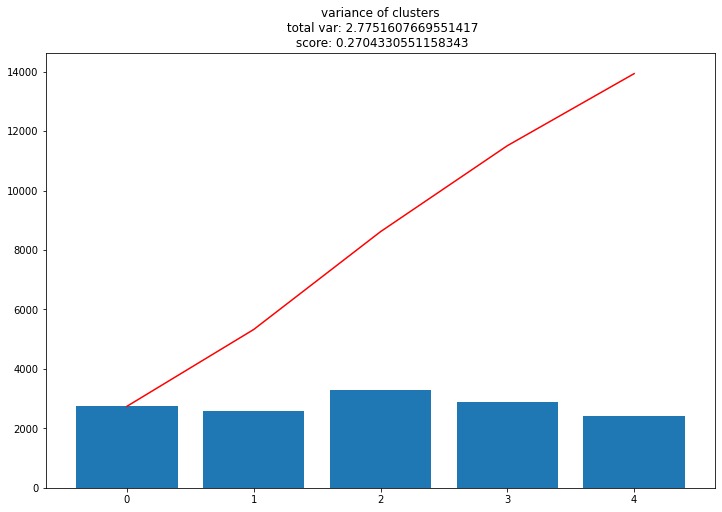

In [907]:
fig,ax=plt.subplots(1,1,figsize=(12,8))
ax.set_title(f'variance of clusters\n total var: {vars.sum()}\n score: {km.sc}')
vars=km.score_variance()
ax.bar(range(len(vars)),
       vars,
       tick_label = list(range(len(vars))))

ax.plot(range(len(vars)),vars.cumsum(),c='red')
plt.show()

# Choosing cols, OneHotEncoder, standarization

In [908]:
df=df.fillna(0)

num_cols=[col for col in df.columns if df[col].dtype!='object']
cat_cols=[col for col in df.columns if df[col].dtype=='object']
cat_cols.remove('make')

enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(df[cat_cols])


X_cat=enc.transform(df[cat_cols]).toarray()
X_num=df[num_cols].to_numpy()

scale=StandardScaler().fit(X_num)
X_num=scale.transform(X_num)

X=np.hstack([X_num,X_cat])

X=[X_num, X]

# autos ndim

In [909]:
km_autos= [KMeans(k_clusters=6) for i in range(2)]
pca=[PCA(n_components=2) for i in range(2)]

for i in range(2):
    km_autos[i].fit(X[i])
    km_autos[i].predict(n_init=100)
    pca[i].fit(X[i])

X_r=[pca[i].transform(X[i]) for i in range(2)]
centers=[pca[i].transform(np.nan_to_num(km_autos[i].C, 0)) for i in range(2)]

# plot ndim autos

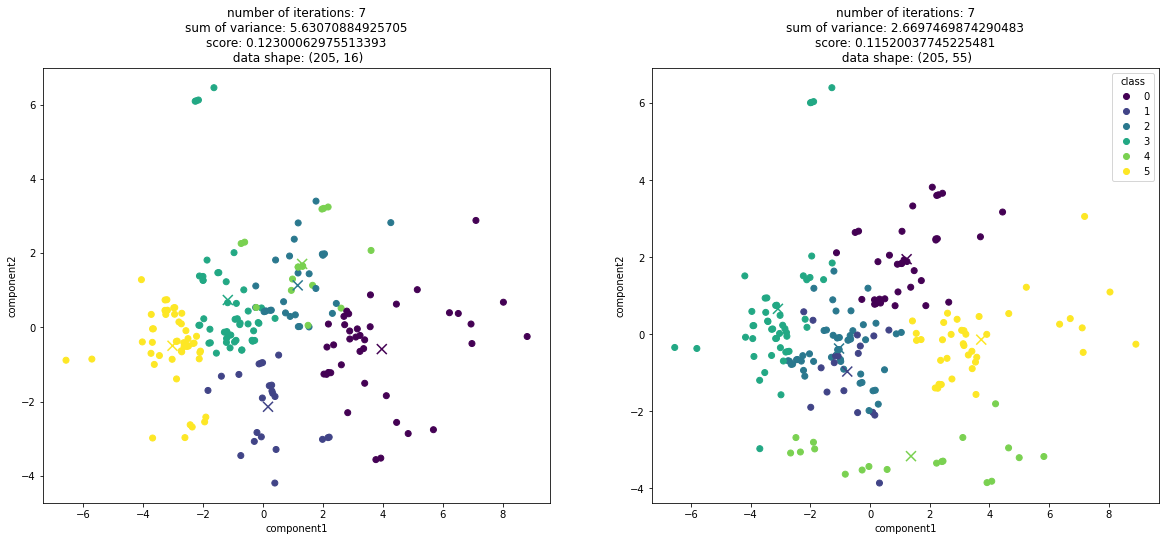

In [910]:
fig,ax=plt.subplots(1,2,figsize=(20,8))

for i in range(2):
    vars=km_autos[i].score_variance()
    ax[i].set_title(f'number of iterations: {km_autos[i].n_iter}\nsum of variance: {vars.sum()}\nscore: {km_autos[i].sc}\n data shape: {km_autos[i].X.shape}')
    ax[i].set_xlabel('component1')
    ax[i].set_ylabel('component2')

    scat=ax[i].scatter(X_r[i][:,0],X_r[i][:,1],c=km_autos[i].P)
    
    plt.legend(handles=scat.legend_elements()[0], labels=list(range(km_autos[i].k_clusters)), title="class")
    ax[i].scatter(centers[i][:,0],centers[i][:,1],c=list(range(km_autos[i].k_clusters)), marker='x',s=100)

plt.show()

# vars

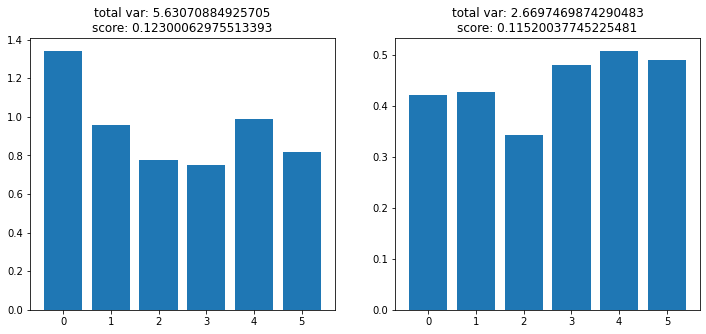

In [911]:
fig,ax=plt.subplots(1,2,figsize=(12,5))

for i in range(2):
    vars=km_autos[i].score_variance()
    
    ax[i].set_title(f'total var: {vars.sum()}\nscore: {km_autos[i].sc}')
    ax[i].bar(range(len(vars)),
        vars,
        tick_label = list(range(len(vars))))

    #ax[i].plot(range(len(km_autos[i].vars)),km_autos[i].vars.cumsum(),c='red')
    
plt.show()

In [912]:
df['claster']=clasters

# euclidean vs mahalanobis

In [913]:
n_points=100

mesh=np.meshgrid(np.linspace(0,1,n_points) , np.linspace(0,1,n_points))
data = np.vstack([mesh[0].ravel(),mesh[1].ravel()]).T

km=KMeans(k_clusters=20)

km.fit(data)

seed=0
n_iters=100
n_init=10

In [914]:
np.random.seed(seed)
predicted_euclidean=km.predict('euclidean',n_iterations=n_iters,n_init=n_init).reshape(n_points,n_points)
n_euclidean=km.n_iter
C_euclidean=km.C
np.random.seed()

In [915]:
np.random.seed(seed)
predicted_mahalanobis=km.predict('mahalanobis',n_iterations=n_iters,n_init=n_init).reshape(n_points,n_points)
n_mahalanobis=km.n_iter
C_mahalanobis=km.C
np.random.seed()

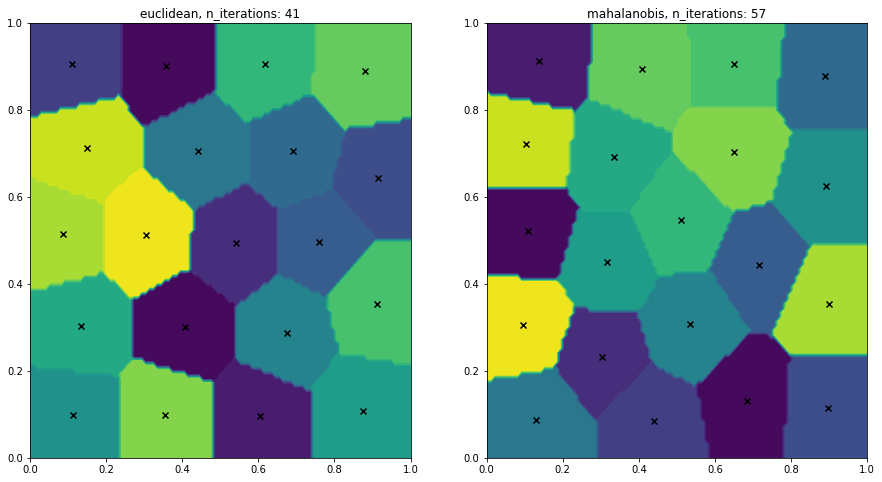

In [916]:
fig,ax=plt.subplots(1,2,figsize=(15,8))
ax[0].set_title(f'euclidean, n_iterations: {n_euclidean}')
ax[1].set_title(f'mahalanobis, n_iterations: {n_mahalanobis}')


ax[0].contourf(mesh[0], mesh[1], predicted_euclidean, levels=km.k_clusters)
ax[0].scatter(C_euclidean[:,0], C_euclidean[:,1], marker='x', c='k')

ax[1].contourf(mesh[0], mesh[1], predicted_mahalanobis, levels=km.k_clusters)
ax[1].scatter(C_mahalanobis[:,0], C_mahalanobis[:,1], marker='x', c='k')

plt.show()